In [1]:
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import zipfile
import glob
import rasterio
import yt
from yt import derived_field
import yt.extensions.geotiff

### Download the data

In [2]:
# Copernicus scihub login details
user = 'username'
password = 'password'

In [3]:
api = SentinelAPI(
    user=user,
    password=password,
    api_url="https://scihub.copernicus.eu/dhus/",
)

geojson = read_geojson('footprint.geojson')
footprint = geojson_to_wkt(geojson)
date = ('NOW-30DAYS','NOW')
producttype = 'S2MSI2A'

products = api.query(footprint, date=date, producttype=producttype)

In [4]:
product_df = api.to_dataframe(products)\
                .sort_values(['cloudcoverpercentage', 'ingestiondate'], ascending=[True, True])\
                .head(1)

In [5]:
product_df[['cloudcoverpercentage', 'ingestiondate']] # hopefully we have an image with little cloud.

,cloudcoverpercentage,ingestiondate
b79201de-eb46-49d1-b084-a5b6f974aa55,5.706001,2020-06-01 19:19:50.305


In [6]:
api.download_all(product_df.index)

({'b79201de-eb46-49d1-b084-a5b6f974aa55': {'id': 'b79201de-eb46-49d1-b084-a5b6f974aa55',
   'title': 'S2A_MSIL2A_20200601T113331_N0214_R080_T30UVG_20200601T123416',
   'size': 1161457671,
   'md5': 'F32ED0101E07B737A048A877D64541BA',
   'date': datetime.datetime(2020, 6, 1, 11, 33, 31, 24000),
   'footprint': 'POLYGON((-4.6014404 55.93532706141405,-2.8437195 55.945635321533295,-2.8475952 54.9590033589594,-4.561981 54.94906599057673,-4.6014404 55.93532706141405))',
   'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('b79201de-eb46-49d1-b084-a5b6f974aa55')/$value",
   'Online': True,
   'Creation Date': datetime.datetime(2020, 6, 1, 19, 20, 8, 102000),
   'Ingestion Date': datetime.datetime(2020, 6, 1, 19, 19, 50, 305000),
   'path': './S2A_MSIL2A_20200601T113331_N0214_R080_T30UVG_20200601T123416.zip',
   'downloaded_bytes': 0}},
 {},
 {})

### Unzip and export 20m resolution bands to GeoTIFF

In [7]:
s2zipfile = product_df.title.tolist()[0] + '.zip'
with zipfile.ZipFile(s2zipfile, 'r') as zip_ref:
    zip_ref.extractall('.')
s2ds = product_df.title.tolist()[0] + '.SAFE'

In [8]:
s2r20m_files = sorted(glob.glob(s2ds + '/GRANULE/**/IMG_DATA/R20m/*_20m.jp2', recursive=True))

In [9]:
bands = {}
ignored_bands = ['AOT', 'TCI', 'WVP', 'SCL'] # we just want the numbered bands
for f in s2r20m_files:
    label = f.split('_')[-2]
    if any([label == ignored_band for ignored_band in ignored_bands]): continue
    bands[label] = rasterio.open(f, driver='JP2OpenJPEG')

In [10]:
#export multiband geotiff image
filename = product_df.title.tolist()[0] + '_20m.tif'
geotiff = rasterio.open(filename,'w',driver='Gtiff',
                         width=bands['B04'].width, height=bands['B04'].height,
                         count=len(bands.keys()),
                         crs=bands['B04'].crs,
                         transform=bands['B04'].transform,
                         dtype=bands['B04'].dtypes[0]
                         )
for i, label in enumerate(bands.keys()):
    geotiff.write(bands[label].read(1), i + 1)
geotiff.close()

In [11]:
list(bands.keys()) # this order

['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B11', 'B12', 'B8A']

We have produced a geotiff from the Sentinel 2 20m resolution data we downloaded. The next step could be to load it into yt and see what we get!

### Read GeoTIFF with yt

In [12]:
ds = yt.load(filename)

yt : [INFO     ] 2020-06-16 17:56:07,187 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-06-16 17:56:07,189 Parameters: domain_dimensions         = [5490 5490    1]
yt : [INFO     ] 2020-06-16 17:56:07,191 Parameters: domain_left_edge          = [0. 0. 0.] m
yt : [INFO     ] 2020-06-16 17:56:07,194 Parameters: domain_right_edge         = [1.0981e+05 1.0981e+05 1.0000e+00] m
yt : [INFO     ] 2020-06-16 17:56:07,207 Parameters: cosmological_simulation   = False


In [13]:
ds.field_list

[('bands', '1'),
 ('bands', '2'),
 ('bands', '3'),
 ('bands', '4'),
 ('bands', '5'),
 ('bands', '6'),
 ('bands', '7'),
 ('bands', '8'),
 ('bands', '9')]

In [14]:
ds.parameters

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 5490,
 'height': 5490,
 'count': 9,
 'crs': CRS.from_epsg(32630),
 'transform': Affine(20.0, 0.0, 399960.0,
        0.0, -20.0, 6200040.0)}

### Normalised Difference Vegetation Index (NDVI)

Here is an example of one thing we can easily calculate once the data is loaded into yt. The [Normalised Difference Vegetation Index](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index)! This is used to monitor vegetation density and health by comparing the reflectance of red (R) and near infrared (NIR) bands.
For our case here the NIR band is the 9 band in the GeoTIFF we created and the R band is 3.

In [15]:
@derived_field(name="ndvi", units="", force_override=True, display_name='NDVI', take_log=False)
def _ndvi(field, data):
    return (data[('bands', '9')] - data[('bands', '3')]) /(data[('bands', '9')] + data[('bands', '3')])

/Users/dane/anaconda/envs/yt-dev/lib/python3.8/site-packages/yt/fields/local_fields.py:46: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  warnings.warn("Because 'sampling_type' not specified, yt will "


In [16]:
ds.add_field("ndvi", function=_ndvi, units="")

<ipython-input-16-ed05cbf4ab2d>:1: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  ds.add_field("ndvi", function=_ndvi, units="")


In [17]:
ad = ds.all_data()

/Users/dane/anaconda/envs/yt-dev/lib/python3.8/site-packages/yt/units/yt_array.py:1416: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(np.asarray(inps[0]), np.asarray(inps[1]),
yt : [INFO     ] 2020-06-16 18:13:00,454 xlim = 41095.000000 150905.000000
yt : [INFO     ] 2020-06-16 18:13:00,455 ylim = 40095.000000 149905.000000
yt : [INFO     ] 2020-06-16 18:13:00,456 xlim = 41095.000000 150905.000000
yt : [INFO     ] 2020-06-16 18:13:00,460 ylim = 40095.000000 149905.000000
yt : [INFO     ] 2020-06-16 18:13:00,466 Making a fixed resolution buffer of (('bands', 'ndvi')) 800 by 800
yt : [WARNING  ] 2020-06-16 18:13:02,423 Plot image for field ('bands', 'ndvi') has both positive and negative values. Min = -0.953479, Max = 0.960362.
yt : [WARNING  ] 2020-06-16 18:13:02,424 Switching to symlog colorbar scaling unless linear scaling is specified later
/Users/dane/anaconda/envs/yt-dev/lib/python3.8/site-packages/yt/visualization/base_plot_types.py:220: MatplotlibDepre


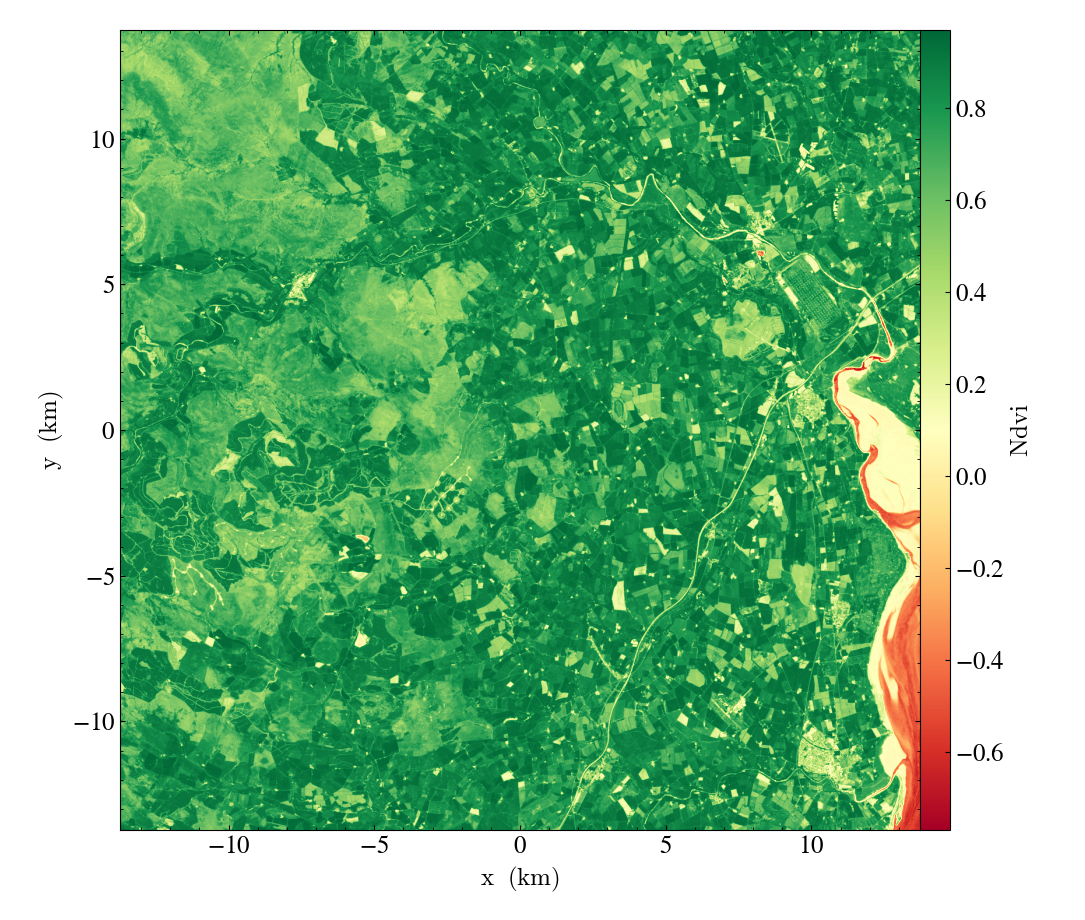

In [38]:
sp = ds.sphere(ds.domain_center, ds.domain_width[0]/4)
p = yt.SlicePlot(ds, 'z', 'ndvi', data_source=sp)
p.set_cmap(field="ndvi", cmap='RdYlGn')
p.set_log("ndvi", False)
p.zoom(4)